In [1]:
import torch, torchvision
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import pyro
import tqdm
import os, pickle, re, copy
import common

ModuleNotFoundError: No module named 'pyro'

In [41]:
# Reproducibility
common.set_seed(156)

In [42]:
class NN(torch.nn.Module):
    def __init__(self, ni, nh, no):
        super(NN, self).__init__()
        self.A = torch.nn.Linear(ni, nh)
        self.relu = torch.nn.ReLU()
        self.B = torch.nn.Linear(nh, no)
    def forward(self, x):
        # Two layer neural network
        x = self.B(self.relu(self.A(x)))
        return x

In [43]:
net = NN(28*28, 1024, 10)

In [44]:
def model(x, y):
    # Put priors on weights and biases 
    priors = {
        "A.weight": pyro.distributions.Normal(
            loc=torch.zeros_like(net.A.weight), 
            scale=torch.ones_like(net.A.weight),
        ).independent(2),
        "A.bias": pyro.distributions.Normal(
            loc=torch.zeros_like(net.A.bias), 
            scale=torch.ones_like(net.A.bias),
        ).independent(1),
        "B.weight": pyro.distributions.Normal(
            loc=torch.zeros_like(net.B.weight), 
            scale=torch.ones_like(net.B.weight),
        ).independent(2),
        "B.bias": pyro.distributions.Normal(
            loc=torch.zeros_like(net.B.bias), 
            scale=torch.ones_like(net.B.bias),
        ).independent(1),
    }
    # Create a NN module using the priors
    lmodule = pyro.random_module("module", net, priors)
    regressor = lmodule()
    # Do a forward pass on the NN module, i.e. yhat=f(x) and condition on yhat=y
    lhat = torch.nn.LogSoftmax(dim=1)(regressor(x))
    pyro.sample("obs", pyro.distributions.Categorical(logits=lhat).independent(1), obs=y)

In [45]:
softplus = torch.nn.Softplus()
def guide(x, y):
    # Create parameters for variational distribution priors
    Aw_mu = pyro.param("Aw_mu", torch.randn_like(net.A.weight))
    Aw_sigma = softplus(pyro.param("Aw_sigma", torch.randn_like(net.A.weight)))
    Ab_mu = pyro.param("Ab_mu", torch.randn_like(net.A.bias))
    Ab_sigma = softplus(pyro.param("Ab_sigma", torch.randn_like(net.A.bias)))
    Bw_mu = pyro.param("Bw_mu", torch.randn_like(net.B.weight))
    Bw_sigma = softplus(pyro.param("Bw_sigma", torch.randn_like(net.B.weight)))
    Bb_mu = pyro.param("Bb_mu", torch.randn_like(net.B.bias))
    Bb_sigma = softplus(pyro.param("Bb_sigma", torch.randn_like(net.B.bias)))
    # Create random variables similarly to model
    priors = {
        "A.weight": pyro.distributions.Normal(loc=Aw_mu, scale=Aw_sigma).independent(2),
        "A.bias": pyro.distributions.Normal(loc=Ab_mu, scale=Ab_sigma).independent(1),
        "B.weight": pyro.distributions.Normal(loc=Bw_mu, scale=Bw_sigma).independent(2),
        "B.bias": pyro.distributions.Normal(loc=Bb_mu, scale=Bb_sigma).independent(1),
    }
    # Return NN module from these random variables
    lmodule = pyro.random_module("module", net, priors)
    return lmodule()

In [46]:
# Do stochastic variational inference to find q(w) closest to p(w|D)
svi = pyro.infer.SVI(
    model, guide, pyro.optim.Adam({'lr': 0.01}), pyro.infer.Trace_ELBO(),
)

In [47]:
def train_and_save_models(epochs = 10, K = 100, modelname = "model.pt"):
    if os.path.exists(modelname):
        print("File exists")
        return
    # Train with SVI
    for epoch in range(epochs):
        loss = 0.
        for data in train_loader:
            images, labels = data
            images = images.view(-1, 28*28)
            loss += svi.step(images, labels)
        loss /= len(train_loader.dataset)
        print("Epoch %g: Loss = %g" % (epoch, loss))
    # Sample k models from the posterior
    sampled_models = [guide(None, None) for i in range(K)]
    # Save the models
    nn_dicts = []
    for i in range(len(sampled_models)):
        nn_dicts += [sampled_models[i].state_dict()]
    torch.save(nn_dicts, modelname)
    print("Saved %d models" % K)

In [48]:
def load_models(K = 100, model_name="model.pt"):
    # Load the models
    sampled_models = [NN(28*28, 1024, 10) for i in range(K)]
    for net, state_dict in zip(sampled_models, torch.load("models/%s" % model_name)):
        net.load_state_dict(state_dict)
    print("Loaded %d sample models" % K)
    return sampled_models

train_and_save_models(epochs = 10, K = 100, modelname = "model.pt")

## Training BNN with Adversarial Examples

### Populate Train Set

In [10]:
# Train dataset
train_dataset = torchvision.datasets.MNIST('.', train=True, download=True,
                       transform=torchvision.transforms.ToTensor())

#### loading adversarial examples

In [11]:
dirs    = [d for d in os.listdir("mnist_adv/") if d.startswith("train_images_med")]
dir_ord = sorted([int(re.findall("[0-9]+",d)[0]) for d in dirs])
dirs    = sorted(dirs, key=lambda x: dir_ord.index(int(re.findall("[0-9]+",x)[0])))

In [12]:
images  = []
targets = []
for d in dirs[:100]:
    with open("mnist_adv/" + d, 'rb') as handle:
        temp = pickle.load(handle)
        images.append(temp["images"])
        targets.append(temp["labels"])
        
images  = torch.vstack(images)
targets = torch.hstack(targets)

In [13]:
train_dataset.data    = torch.vstack([train_dataset.data, images])
train_dataset.targets = torch.hstack([train_dataset.targets, targets])

train, val = random_split(train_dataset,[50000+images.shape[0],10000], generator=torch.Generator().manual_seed(156))

# Train data loader
train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val  , batch_size=128, shuffle=True)

In [14]:
img = next(iter(train_loader))

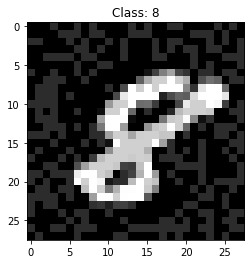

In [27]:
ind = 9 # try 1
plt.figure()
plt.imshow(img[0][ind,0,:,:], cmap='gray')
plt.title("Class: %s" % img[1][ind].item())
plt.show()

## Model Training

### AdvBNN

In [92]:
epochs = 20
K = 100
modelname = "AdvBNN"
# Train with SVI
val_losses = []
for epoch in range(epochs):
    loss = 0.
    for data in train_loader:
        images, labels = data
        images = images.view(-1, 28*28)
        loss  += svi.step(images, labels)
    loss /= len(train_loader.dataset)
    # Evaluation
    val_loss = 0.
    for data in val_loader:
        images, labels = data
        images = images.view(-1, 28*28)
        val_loss += svi.evaluate_loss(images, labels)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    print("Epoch %g: Loss = %g: Val_Loss = %g" % (epoch, loss,val_loss))
    if val_loss == min(val_losses):
        print("New minimum loss was reached")
        # Sample k models from the posterior
        sampled_models = [guide(None, None) for i in range(K)]
        # Save the models
        nn_dicts = []
        for i in range(len(sampled_models)):
            nn_dicts += [sampled_models[i].state_dict()]
        torch.save(nn_dicts, "models/%s_%s.pt" % (modelname, val_loss))
        print("Saved %d models" % K)

Epoch 0: Loss = 224.907: Val_Loss = 155.048
New minimum loss was reached
Saved 100 models
Epoch 1: Loss = 126.228: Val_Loss = 110.348
New minimum loss was reached
Saved 100 models
Epoch 2: Loss = 102.098: Val_Loss = 96.711
New minimum loss was reached
Saved 100 models
Epoch 3: Loss = 94.6596: Val_Loss = 92.7928
New minimum loss was reached
Saved 100 models
Epoch 4: Loss = 90.8076: Val_Loss = 89.341
New minimum loss was reached
Saved 100 models
Epoch 5: Loss = 89.4689: Val_Loss = 89.0899
New minimum loss was reached
Saved 100 models
Epoch 6: Loss = 89.256: Val_Loss = 87.3815
New minimum loss was reached
Saved 100 models
Epoch 7: Loss = 89.206: Val_Loss = 89.2695
Epoch 8: Loss = 88.9558: Val_Loss = 88.0049
Epoch 9: Loss = 89.5115: Val_Loss = 88.6798
Epoch 10: Loss = 89.0705: Val_Loss = 89.7829
Epoch 11: Loss = 89.3799: Val_Loss = 90.5028
Epoch 12: Loss = 89.4893: Val_Loss = 90.1578
Epoch 13: Loss = 89.1492: Val_Loss = 88.9892
Epoch 14: Loss = 88.8912: Val_Loss = 88.2839
Epoch 15: Loss = 

### AdvFFNN

In [ ]:
# HyperParameters
epochs = 15
K      = 100
modelname = "AdvFFNN"
lr     = 0.01

# Train with BinaryCrossEntropy
val_losses = []
model = NN(28*28, 1024, 10)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fcn  = torch.nn.CrossEntropyLoss()

for epoch in range(epochs):
    total_loss = 0.
    model.train()
    for data in train_loader:
        images, labels = data
        images = images.view(-1, 28*28)
        y = model(images)
        loss = loss_fcn(y, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
        total_loss += loss.item()
    total_loss /= len(train_loader.dataset)
    # Evaluation
    val_loss = 0.
    model.eval()
    for data in val_loader:
        images, labels = data
        y    = model(images)
        loss = loss_fcn(y, labels)
        val_loss += loss.item()
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    print("Epoch %g: Loss = %g: Val_Loss = %g" % (epoch, total_loss,val_loss))
    if val_loss == min(val_losses):
        print("New minimum loss was reached")
        # Sample k models from the posterior
        sampled_models = [guide(None, None) for i in range(K)]
        # Save the models
        nn_dicts = []
        for i in range(len(sampled_models)):
            nn_dicts += [sampled_models[i].state_dict()]
        torch.save(nn_dicts, "models/%s_ep%s_loss%s.pt" % (modelname, val_loss))
        print("Saved %d models" % K)

In [28]:
# HyperParameters
epochs = 10
K      = 100
modelname = "AdvFFNN"
lr     = 0.01

# Train with BinaryCrossEntropy
val_losses = []
model = NN(28*28, 1024, 10)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fcn  = torch.nn.CrossEntropyLoss(reduce="mean")

for epoch in range(epochs):
    total_loss = 0.
    model.train()
    for data in train_loader:
        images, labels = data
        images = images.view(-1, 28*28)
        y = model(images)
        loss = loss_fcn(y, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
        total_loss += loss.item()
    total_loss /= len(train_loader.dataset)
    print("Epoch %g: Loss = %g" % (epoch, total_loss))

torch.save(model, "models/%s.pt" % modelname)
print("Saved the model")

Epoch 0: Loss = 0.00185364
Epoch 1: Loss = 0.000930323
Epoch 2: Loss = 0.00073556
Epoch 3: Loss = 0.000583742
Epoch 4: Loss = 0.00055748
Epoch 5: Loss = 0.000542039
Epoch 6: Loss = 0.000428012
Epoch 7: Loss = 0.000463505
Epoch 8: Loss = 0.000365677
Epoch 9: Loss = 0.000414745
Saved the model


## Evaluate Adversarial Test Loss

### Median Adv Test Images

In [49]:
dirs = [d for d in os.listdir("mnist_adv/") if "test_images_med" in d]

images  = []
targets = []
for d in dirs:
    with open("mnist_adv/"+d, 'rb') as handle:
        temp = pickle.load(handle)
        images.append(temp["images"])
        targets.append(temp["labels"])
        
images  = torch.vstack(images)
targets = torch.hstack(targets)


In [50]:
# Test dataset
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True,
                       transform=torchvision.transforms.ToTensor())
test_dataset.data    = None
test_dataset.targets = None

test_dataset.data    = images
test_dataset.targets = targets

In [51]:
test_loader.dataset.data.shape

torch.Size([12288, 28, 28])

#### Evaluation
test_loss = 0.
for data in test_loader:
    images, labels = data
    images = images.view(-1, 28*28)
    test_loss += svi.evaluate_loss(images, labels)
test_loss /= len(test_loader.dataset)
print("Test_Loss = %g" % (test_loss))


#### Helper Functions

In [53]:
def fooling_rate(sampled_models, adv_image, target):
    fool = 0
    for k in range(len(sampled_models)):
        # Forward pass again on adv. example
        pred = forward_pass(sampled_models[k], adv_image)
        # If we change the class, we fool the model
        fool += int(target != pred)
    return fool/len(sampled_models)

In [54]:
def forward_pass(model, images, loss_target = None):
    output = model(images)
    output = torch.nn.LogSoftmax(dim=-1)(output)
    which_class = torch.argmax(output).item()
    if loss_target:
        loss, target = loss_target
        loss(output, target).backward()
    return which_class

In [55]:
# Test data loader with batch_size 1
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True,
                                         generator=torch.Generator().manual_seed(156))

In [56]:
sampled_models_BNN = load_models(K = 25,model_name="model.pt")
sampled_models_AdvBNN = load_models(K = 25,model_name="AdvBNN_87.3814625.pt")
AdvFFNN = torch.load("models/AdvFFNN.pt")

Loaded 25 sample models
Loaded 25 sample models


In [60]:
# Evaluation
fool_rates_BNN         = []
fool_rates_AdvBNN      = []
fool_rates_AdvBNN_med  = []
fool_rates_AdvFFNN     = []
counter = 1
for images, labels in test_loader:
    print("\r Processing %s / %s" % (counter,len(test_loader.dataset.targets)), end="")
    images = images.view(-1, 28*28)
    fool_rates_BNN.append(fooling_rate(sampled_models_BNN,images,labels))
    fool_rates_AdvBNN.append(fooling_rate(sampled_models_AdvBNN,images,labels))
    fool_rates_AdvBNN_med.append( 1 if fooling_rate(sampled_models_AdvBNN,images,labels) > 0.5 else 0 )
    fool_rates_AdvFFNN.append(fooling_rate([AdvFFNN],images,labels))
    if counter % 2000 == 0 or counter == len(test_loader.dataset.targets):
        bnn_rate      = sum(fool_rates_BNN) / len(fool_rates_BNN)
        advbnn_rate   = sum(fool_rates_AdvBNN) / len(fool_rates_AdvBNN)
        advbnn_rate_m = sum(fool_rates_AdvBNN_med) / len(fool_rates_AdvBNN_med)
        advffnn_rate  = sum(fool_rates_AdvFFNN) / len(fool_rates_AdvFFNN)
        print("\nAdvBNN: %s, BNN %s, AdvBNN_med: %s, AdvFFNN %s\n" % (advbnn_rate, bnn_rate,advbnn_rate_m, advffnn_rate))
    counter += 1

 Processing 1999 / 12288
AdvBNN: 0.5108154077038518, BNN 0.7912156078039062, AdvBNN_med: 0.5102551275637819, AdvFFNN 0.014007003501750876

 Processing 3999 / 12288
AdvBNN: 0.5129082270567661, BNN 0.7876869217304502, AdvBNN_med: 0.5133783445861465, AdvFFNN 0.012253063265816454

 Processing 5999 / 12288
AdvBNN: 0.5137189531588604, BNN 0.7879513252208977, AdvBNN_med: 0.5132522087014503, AdvFFNN 0.012668778129688281

 Processing 7999 / 12288
AdvBNN: 0.5121990248781089, BNN 0.7869583697962678, AdvBNN_med: 0.5114389298662333, AdvFFNN 0.01362670333791724

 Processing 9999 / 12288
AdvBNN: 0.5104230423042277, BNN 0.7858065806581176, AdvBNN_med: 0.5076507650765076, AdvFFNN 0.015201520152015202

 Processing 11999 / 12288
AdvBNN: 0.5104892074339492, BNN 0.7862721893491296, AdvBNN_med: 0.5067088924077007, AdvFFNN 0.015417951495957996

 Processing 12287 / 12288
AdvBNN: 0.5105851713192773, BNN 0.7865581508911961, AdvBNN_med: 0.5071213477659314, AdvFFNN 0.015137950679580044

 Processing 12288 / 12288

fool_rates_AdvBNN

### Champ Adv Test Images

In [61]:
dirs = [d for d in os.listdir("mnist_adv/") if "test_images_champ" in d]

images  = []
targets = []
for d in dirs:
    with open("mnist_adv/"+d, 'rb') as handle:
        temp = pickle.load(handle)
        images.append(temp["images"])
        targets.append(temp["labels"])
        
images  = torch.vstack(images)
targets = torch.hstack(targets)


In [62]:
# Test dataset
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True,
                       transform=torchvision.transforms.ToTensor())
test_dataset.data    = None
test_dataset.targets = None

test_dataset.data    = images
test_dataset.targets = targets

In [63]:
# Test data loader with batch_size 1
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True,
                                         generator=torch.Generator().manual_seed(156))

In [64]:
# Evaluation
fool_rates_BNN         = []
fool_rates_AdvBNN      = []
fool_rates_AdvBNN_med  = []
fool_rates_AdvFFNN     = []
counter = 1
for images, labels in test_loader:
    print("\r Processing %s / %s" % (counter,len(test_loader.dataset.targets)), end="")
    images = images.view(-1, 28*28)
    fool_rates_BNN.append(fooling_rate(sampled_models_BNN,images,labels))
    fool_rates_AdvBNN.append(fooling_rate(sampled_models_AdvBNN,images,labels))
    fool_rates_AdvBNN_med.append( 1 if fooling_rate(sampled_models_AdvBNN,images,labels) > 0.5 else 0 )
    fool_rates_AdvFFNN.append(fooling_rate([AdvFFNN],images,labels))
    if counter % 2000 == 0 or counter == len(test_loader.dataset.targets):
        bnn_rate      = sum(fool_rates_BNN) / len(fool_rates_BNN)
        advbnn_rate   = sum(fool_rates_AdvBNN) / len(fool_rates_AdvBNN)
        advbnn_rate_m = sum(fool_rates_AdvBNN_med) / len(fool_rates_AdvBNN_med)
        advffnn_rate  = sum(fool_rates_AdvFFNN) / len(fool_rates_AdvFFNN)
        print("\nAdvBNN: %s, BNN %s, AdvBNN_med: %s, AdvFFNN %s\n" % (advbnn_rate, bnn_rate,advbnn_rate_m, advffnn_rate))
    counter += 1

 Processing 2000 / 12288
AdvBNN: 0.42992000000000025, BNN 0.5739999999999995, AdvBNN_med: 0.3815, AdvFFNN 0.036

 Processing 4000 / 12288
AdvBNN: 0.4291799999999987, BNN 0.5716300000000026, AdvBNN_med: 0.3835, AdvFFNN 0.03725

 Processing 6000 / 12288
AdvBNN: 0.4307333333333291, BNN 0.5744866666666713, AdvBNN_med: 0.387, AdvFFNN 0.038

 Processing 8000 / 12288
AdvBNN: 0.43043999999999366, BNN 0.5755900000000099, AdvBNN_med: 0.386, AdvFFNN 0.038

 Processing 10000 / 12288
AdvBNN: 0.4299399999999926, BNN 0.5748160000000144, AdvBNN_med: 0.3854, AdvFFNN 0.0364

 Processing 12000 / 12288
AdvBNN: 0.4293733333333202, BNN 0.5734866666666837, AdvBNN_med: 0.38458333333333333, AdvFFNN 0.03675

 Processing 12288 / 12288
AdvBNN: 0.4299251302083193, BNN 0.5734700520833509, AdvBNN_med: 0.3848470052083333, AdvFFNN 0.036946614583333336

